<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/pathomics/microscopy_dicom_ann_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with DICOM Microscopy Bulk Simple Annotations in computational pathology


This tutorial is shared as part of the tutorials prepared by the Imaging Data Commons team and available at https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks.

If you are new to IDC and DICOM for digital pathology applications, you may want to check out other introductory tutorials on this topic available here: https://github.com/ImagingDataCommons/IDC-Tutorials/tree/master/notebooks/pathomics.

This tutorial is aimed for the users of Imaging Data Commons that are interested to understand how to use annotations of slide microscopy images. You will learn how to:
* select and download specific type of slide annotations, represented as polygons
* parse the content annotations stored in DICOM Bulk Simple Annotations (ANN) format
* utilize annotations for calculating quantitative features that may help in analyzing the annotated pathology slides

To learn more about the IDC, please visit the [IDC user guide](https://learn.canceridc.dev).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev)!

----------------------

Initial version: Jan 2025

## Background

There are different ways to store annotations in DICOM, depending on the type of the annotation, and the specific DICOM object used. The annotations of cell nuclei in the [`Pan-Cancer-Nuclei-Seg-DICOM` collection](https://zenodo.org/records/14009675), which were recently added to the [NCI Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/explore/filters/?analysis_results_id=Pan-Cancer-Nuclei-Seg-DICOM), are offered in two formats:
1. Polygons corresponding to the boundaries of the nuclei: DICOM **Microscopy Simple Bulk Annotations** (ANN)
2. Binary masks labeling the areas of the image corresponding to the individual nuclei: DICOM Segmentations (SEG)

In this notebook we will concentrate on the first format, discuss how DICOM ANN objects in the `Pan-Cancer-Nuclei-Seg-DICOM` collection are organized and how those annotations can be used in analysis. The DICOM SEG format will be covered later and then linked here upon finalization.

`Pan-Cancer-Nuclei-Seg-DICOM` contains **automatically derived nucleus segmentations** in over 5000 whole slide tissue images across 10 different cancer types. The annotations correspond to digital pathology images from the TCGA collections, all of which are available in the IDC:

- Bladder urothelial carcinoma (TCGA-BLCA)
- Breast invasive carcinoma (TCGA-BRCA)
- Cervical squamous cell carcinoma and endocervical adenocarcinoma (TCGA-CESC)
- Glioblastoma Multiforme (TCGA-GBM)
- Lung adenocarcinoma (TCGA-LUAD)
- Lung squamous cell carcinoma (TCGA-LUSC)
- Pancreatic adenocarcinoma (TCGA-PAAD)
- Prostate adenocarcinoma (TCGA-PRAD)
- Skin Cutaneous Melanoma (TCGA-SKCM)
- Uterine Corpus Endometrial Carcinoma (TCGA-UCEC)

Originally released by [TCIA in SVS format](https://www.cancerimagingarchive.net/analysis-result/pan-cancer-nuclei-seg/), the collection is now harmonized into DICOM format and freely available in IDC. While the Zenodo page [Pan-Cancer-Nuclei-Seg-DICOM: DICOM converted Dataset of Segmented Nuclei in Hematoxylin and Eosin Stained Histopathology Images](https://zenodo.org/records/14009675) offers download manifests for the complete collection, in this notebook we demonstrate how to navigate its content programmatically.

## Example

As an example, you can open the sample slide and annotations available here https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.150973379448125660359643882019624926008/series/1.3.6.1.4.1.5962.99.1.1062471168.429178244.1637445043712.2.0. Note that not all of the slides in a given study contain annotations. Make sure you select the slide that has the suffix "DX1", as shown in the screenshot below. To enable visualization of the annotations, open "Annotation Groups" section in the right panel, and toggle "Nuclei" switch.

<img src="https://raw.githubusercontent.com/ImagingDataCommons/IDC-Tutorials/master/notebooks/pathomics/pan_cancer_annotation_slim_example.png" alt="Example visualization of annotations" width="1000"/>

## Prerequisites
**Installations**
* **Install highdicom:** Most code in this notebook relies on the Python library [highdicom](https://highdicom.readthedocs.io/en/latest/introduction.html) which was specifically designed to work with DICOM objects holding image-derived information, e.g. annotations and measurements. Further and more detailed information on highdicom's functionality can be found in its [user guide](https://highdicom.readthedocs.io/en/latest/usage.html).
* **Install wsidicom:** The [wsidicom](https://pypi.org/project/wsidicom/) Python package provides functionality to open and extract image or metadata from WSIs.
* **Install idc-index:** The Python package [idc-index](https://pypi.org/project/idc-index/) facilitates queries of the basic metadata and download of DICOM files hosted by the IDC.

In [ ]:
%%capture
!pip install highdicom
!pip install wsidicom
!pip install idc-index --upgrade

## Imports

In [ ]:
import os
import random
import subprocess
import pandas as pd
import numpy as np
import highdicom as hd
import matplotlib.pyplot as plt
from idc_index import index
from wsidicom import WsiDicom
from typing import List, Tuple, Union
import shapely
from shapely.geometry import Polygon, box
from shapely.strtree import STRtree
from PIL import Image, ImageDraw
from shapely.affinity import translate

## Accessing DICOM ANNs from the IDC
To access and download the ANNs files, we utilize the Python package [idc-index](https://github.com/ImagingDataCommons/idc-index) that facilitates querying metadata and downloading DICOM files from the IDC. Since all available ANN documents in the IDC have a combined size of 1.82 TB - for the demonstration in this tutorial we will use only a single ANN from the TCGA-BRCA collection as an example.

In [ ]:
idc_client = index.IDCClient() # set-up idc_client
idc_client.fetch_index('sm_instance_index')

In [ ]:
query_sr = '''
SELECT
    SeriesInstanceUID,
    StudyInstanceUID,
    PatientID,
    collection_id
FROM
    index
WHERE
    analysis_result_id = 'Pan-Cancer-Nuclei-Seg-DICOM' AND Modality = 'ANN' AND collection_id = 'tcga_luad'
ORDER BY
    crdc_series_uuid
LIMIT 1
'''
pan_ann = idc_client.sql_query(query_sr)

In [ ]:
dcm_ann_dir = '/content/dicom_ann_annotations'
os.makedirs(dcm_ann_dir, exist_ok=True)

idc_client.download_from_selection(downloadDir=dcm_ann_dir,
                                   seriesInstanceUID=pan_ann['SeriesInstanceUID'].tolist(), dirTemplate=None)

Annotations can also be viewed and explored in detail on its respective slide using the Slim viewer. In the Slim viewer's interface select the slide `TCGA-06-6562-01Z-00-DX1` on the left sidebar, click on `Annotation Groups` at the bottom of the right sidebar and switch the slider(s) to make annotations visible.

In [ ]:
viewer_url = idc_client.get_viewer_URL(studyInstanceUID=pan_ann['StudyInstanceUID'].iloc[0], viewer_selector='slim')
from IPython.display import IFrame
IFrame(viewer_url, width=1500, height=900)

## Reading DICOM ANNs

DICOM ANNs extend the capabilities of [DICOM Structured Report (SR)](https://highdicom.readthedocs.io/en/latest/generalsr.html) documents as they were developed specifically for the storage of a **large number of similar annotations** and corresponding measurements (hence the full name Microscopy Simple **Bulk** Annotations). A popular example are annotations of small structures like cells or cell nuclei.

Each ANN object contains one or more "Annotation Groups" consisting of many similar graphical annotations, optionally accompanied by one or several numerical measurements belonging to those graphical annotations as well as some required and some optional metadata that describe the contents of the group (see [here](https://highdicom.readthedocs.io/en/latest/package.html#highdicom.ann.AnnotationGroup) for more information).

The following code uses the Python library [highdicom](https://github.com/ImagingDataCommons/highdicom) to extract annotation groups and corresponding measurements from a single DICOM ANN.

In highdicom, the annotation data are encoded as a list of numpy arrays, each of the shape (N x D). N is the number of coordinates which depends on the graphic type, e.g. a `POINT` will have one coordinate, while a `POLYGON` has >= 3 coordinates. Coordinates are either defined in the 2D image coordinate system (D=2), or in the frame-of-reference coordinate system (D=3).

More explanations and guidance through implementation details for ANN objects in highdicom can be found [here](https://highdicom.readthedocs.io/en/latest/ann.html#microscopy-bulk-simple-annotation-ann-objects).

In [ ]:
ann_path_example1 = os.path.join(dcm_ann_dir, os.listdir(dcm_ann_dir)[0])
ann = hd.ann.annread(ann_path_example1)
ann_groups = ann.get_annotation_groups()
print(f'Number of annotation groups: {len(ann_groups)}')

Number of annotation groups: 1


In [ ]:
ann_group = ann_groups[0]
print(f'Label of the annotation group: {ann_group.label}')
print(f'Graphic type of annotations: {ann_group.graphic_type}')
print(f'Number of annotations: {ann_group.number_of_annotations}')

Label of the annotation group: Nuclei
Graphic type of annotations: GraphicTypeValues.POLYGON
Number of annotations: 865921


In [ ]:
nuclei_annotations = ann_group.get_graphic_data(coordinate_type='2D')
first_ann = nuclei_annotations[0].tolist()
print(f'First annotation: {first_ann}')

First annotation: [[15950.0, 15620.0], [15949.0, 15621.0], [15948.0, 15621.0], [15946.0, 15623.0], [15946.0, 15626.0], [15947.0, 15627.0], [15947.0, 15632.0], [15949.0, 15634.0], [15950.0, 15634.0], [15951.0, 15635.0], [15954.0, 15635.0], [15955.0, 15634.0], [15956.0, 15634.0], [15958.0, 15632.0], [15958.0, 15631.0], [15959.0, 15630.0], [15959.0, 15624.0], [15958.0, 15623.0], [15958.0, 15622.0], [15957.0, 15622.0], [15956.0, 15621.0], [15955.0, 15621.0], [15954.0, 15620.0]]


As previously mentioned, annotations can be accompanied by one or multiple measurements. For the Pan-Cancer-Nuclei-Seg-DICOM collection these are each nuclei's area given in µm².

In [ ]:
m_names, m_values, m_units = ann_group.get_measurements()
for i, (m_name, _, m_unit) in enumerate(zip(m_names, m_values, m_units)):
    print(f'Measurements for "{m_name.CodeMeaning}" in unit "{m_unit.CodeMeaning}"')
    print(m_values[:,i-1])

Measurements for "Area" in unit "square micrometer"
[11.367216 21.59136   4.699296 ...  7.429968  5.905872  3.111696]


## Making use of annotations: Compute cellularity per tile

Having learned the basics of how to search for and access bulk annotations in the IDC, the question arises on how to use them for analysis and in combination with the WSIs to which they refer. As an example, we outline the use case of **estimating cellularity** as the ratio of the area showing cells in comparison to other tissue in a slide. At the same time we keep track of the **number of nuclei** in a certain area, which is also often referred to as cellularity.

The following three code cells contain general utility functions, functions for cellularity computation and finally helper code for visulizations.


In [ ]:
# General utility functionality

def get_nuclei_annotations(ann: hd.ann.sop.MicroscopyBulkSimpleAnnotations) -> np.ndarray:
    annotation_groups = ann.get_annotation_groups()
    assert len(annotation_groups) == 1
    annotation_group = ann.get_annotation_group(number=1)
    nuclei_annotations = annotation_group.get_graphic_data(coordinate_type='2D')
    return nuclei_annotations

def get_referenced_uids(ann: hd.ann.sop.MicroscopyBulkSimpleAnnotations) -> Tuple[str]:
    return ann.ReferencedImageSequence[0].ReferencedSOPInstanceUID, ann.ReferencedSeriesSequence[0].SeriesInstanceUID

def get_image_size_and_pixel_spacing(idc_client: index.IDCClient, sop_instance_uid: str) -> Tuple[int]:
    sop_uid = f"'{sop_instance_uid}'"
    query = f'''
        SELECT
            TotalPixelMatrixColumns as width,
            TotalPixelMatrixRows as height,
        FROM
            sm_instance_index
        WHERE
            SOPInstanceUID in ({sop_uid})
    '''
    query_result = idc_client.sql_query(query)
    return query_result.iloc[0]['width'], query_result.iloc[0]['height']

def get_image_slide(series_instance_uid: str) -> 'WsiDicom':
    idc_client.download_from_selection(seriesInstanceUID=series_instance_uid, downloadDir='.', dirTemplate='%SeriesInstanceUID')
    slide = WsiDicom.open(f'/content/{series_instance_uid}')
    return slide

In [ ]:
# Cellularity computation

def build_r_tree_from_dicom_polygons(polygons: List[np.ndarray]) -> STRtree:
    polygons = [Polygon(p) for p in polygons]
    valid_polygons = [pol for pol in polygons if shapely.is_valid(pol)]
    return STRtree(valid_polygons)

def get_overlapping_polygons_for_tile(r_tree: STRtree, tile_box: box) -> np.ndarray:
    indices_overlapping_polygons = r_tree.query(tile_box, predicate='intersects') # get indices of polygons is partly or as a whole within the tile
    return r_tree.geometries.take(indices_overlapping_polygons)

def compute_cellularity_for_tile(r_tree: STRtree, tile_coords: Tuple[int], tile_size: int) -> Tuple[List[Polygon], float]:

    tile_box = box(tile_coords[0], tile_coords[1], tile_coords[0] + tile_size, tile_coords[1] + tile_size)
    assert shapely.is_valid(tile_box)
    overlapping_polygons = get_overlapping_polygons_for_tile(r_tree, tile_box)
    area_covered_by_nuclei = 0.0
    if overlapping_polygons.size > 0:
        for overlapping_polygon in overlapping_polygons:
            area_covered_by_nuclei += overlapping_polygon.intersection(tile_box).area
        cellularity = (area_covered_by_nuclei / tile_box.area)
    else:
        cellularity = 0.0
    return overlapping_polygons, cellularity

def compute_cellularity_per_tile(slide_size: Tuple[int], tile_size: int, nuclei_annotations: List[np.ndarray]):

    r_tree = build_r_tree_from_dicom_polygons(nuclei_annotations)
    tile_coordinates = []
    cellularities = []
    overlapping_polygons = []
    number_nuclei = []

    (cols, rows) = (slide_size[0] // tile_size, slide_size[1] // tile_size)
    tile_positions = [(tile_pos_x, tile_pos_y) for tile_pos_y in range(0, rows) for tile_pos_x in range(0, cols)]

    for tile_position in tile_positions:
        tile_coords = (tile_position[0] * tile_size, tile_position[1] * tile_size) # compute coordinates in pixel matrix
        tile_coordinates.append(tile_coords)
        op, c = compute_cellularity_for_tile(r_tree, tile_coords, tile_size)
        cellularities.append(c)
        overlapping_polygons.append(op)
        number_nuclei.append(len(op))

    results_dict = {'tile_position': tile_positions, 'tile_coordinates': tile_coordinates,
                    'overlapping_polygons': overlapping_polygons, 'cellularity': cellularities, 'number_nuclei': number_nuclei}
    return pd.DataFrame(results_dict)

In [ ]:
# Visualization

def create_heatmap(cellularity_per_tile):
    tile_pos = np.stack(cellularity_per_tile['tile_position'])
    cellularity = np.stack(cellularity_per_tile['cellularity'])

    max_cols = max([pos[0] for pos in tile_pos]) + 1
    max_rows = max([pos[1] for pos in tile_pos]) + 1
    heatmap = np.zeros((max_rows, max_cols)) # initialize heatmap with 0
    for pos, cell in zip(tile_pos, cellularity):
        heatmap[pos[1], pos[0]] = cell

    return heatmap

def overlay_polygons(tile: Image, tile_coords: tuple, polygons: list) -> Image:
    overlay = Image.new('RGBA', tile.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)

    for polygon in polygons:
        translated_polygon = translate(polygon, xoff=-tile_coords[0], yoff=-tile_coords[1])
        coords = list(translated_polygon.exterior.coords)
        draw.polygon(coords, outline='yellow', width=3) # draw polygons

    result = Image.alpha_composite(tile.convert('RGBA'), overlay)
    return result

In the following, we will compute the cellularity - the ratio of a `TILE_SIZE x TILE_SIZE` sized tissue region showing nuclei compared other tissue - given simply our DICOM ANN file. From this file we can extract the nuclei annotations and the DICOM SOPInstanceUID and SeriesUID of the referenced slide. The cellularity computations can be done without actually looking at the original slide - the only information needed is the image width and height, which can be obtained using the `idc_client`.

Note that the selection of TILE_SIZE is independent from the size of the tiles in the encoded DICOM image!

If you are running this notebook on Google Colab, the following cell should take around 2 minutes to complete.

In [ ]:
TILE_SIZE = 512
ref_sop_instance_uid, ref_series_uid = get_referenced_uids(ann)
nuclei_annotations = get_nuclei_annotations(ann)
image_width, image_height = get_image_size_and_pixel_spacing(idc_client, ref_sop_instance_uid)
cellularity_per_tile = compute_cellularity_per_tile(slide_size=(image_width, image_height), tile_size=512, nuclei_annotations=nuclei_annotations)

The cellularity results per tile are visualized as a heatmap next to a thumbnail of the original slide.

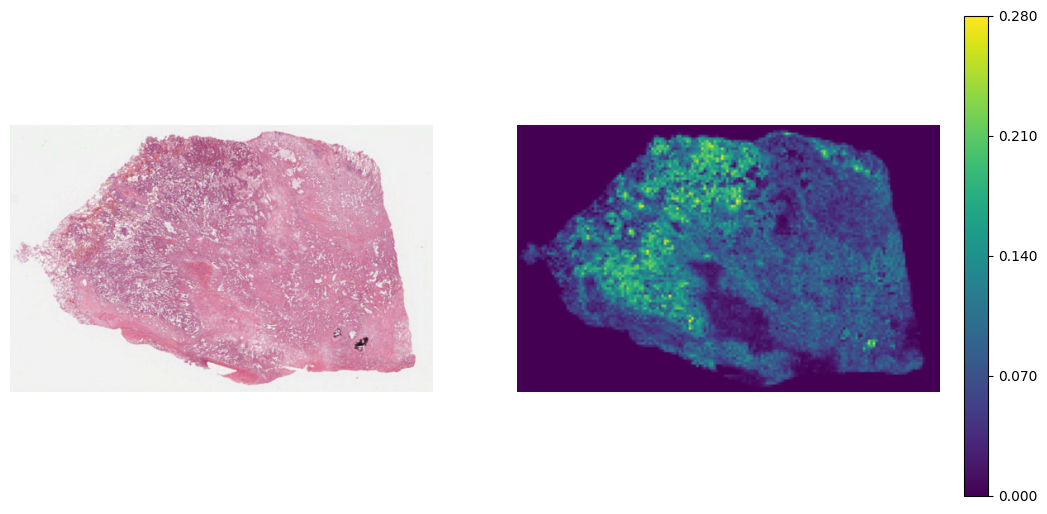

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

slide = get_image_slide(ref_series_uid)
thumbnail = slide.read_thumbnail()
axes[0].imshow(thumbnail)
axes[0].axis('off')

heatmap = create_heatmap(cellularity_per_tile)
min_max_scaled = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
hm = axes[1].imshow(min_max_scaled)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = plt.colorbar(hm, cax=cax)
cbar.set_ticks(np.linspace(0, 1, num=5))
cbar.set_ticklabels([f'{x:.3f}' for x in np.linspace(heatmap.min(), heatmap.max(), num=5)])
axes[1].axis('off')

plt.show()

To finally have a quick-and-easy verifying look on regions of interest - in our case the tiles with the hightest cellularity values - we access those tiles and overlay nuclei annotations.

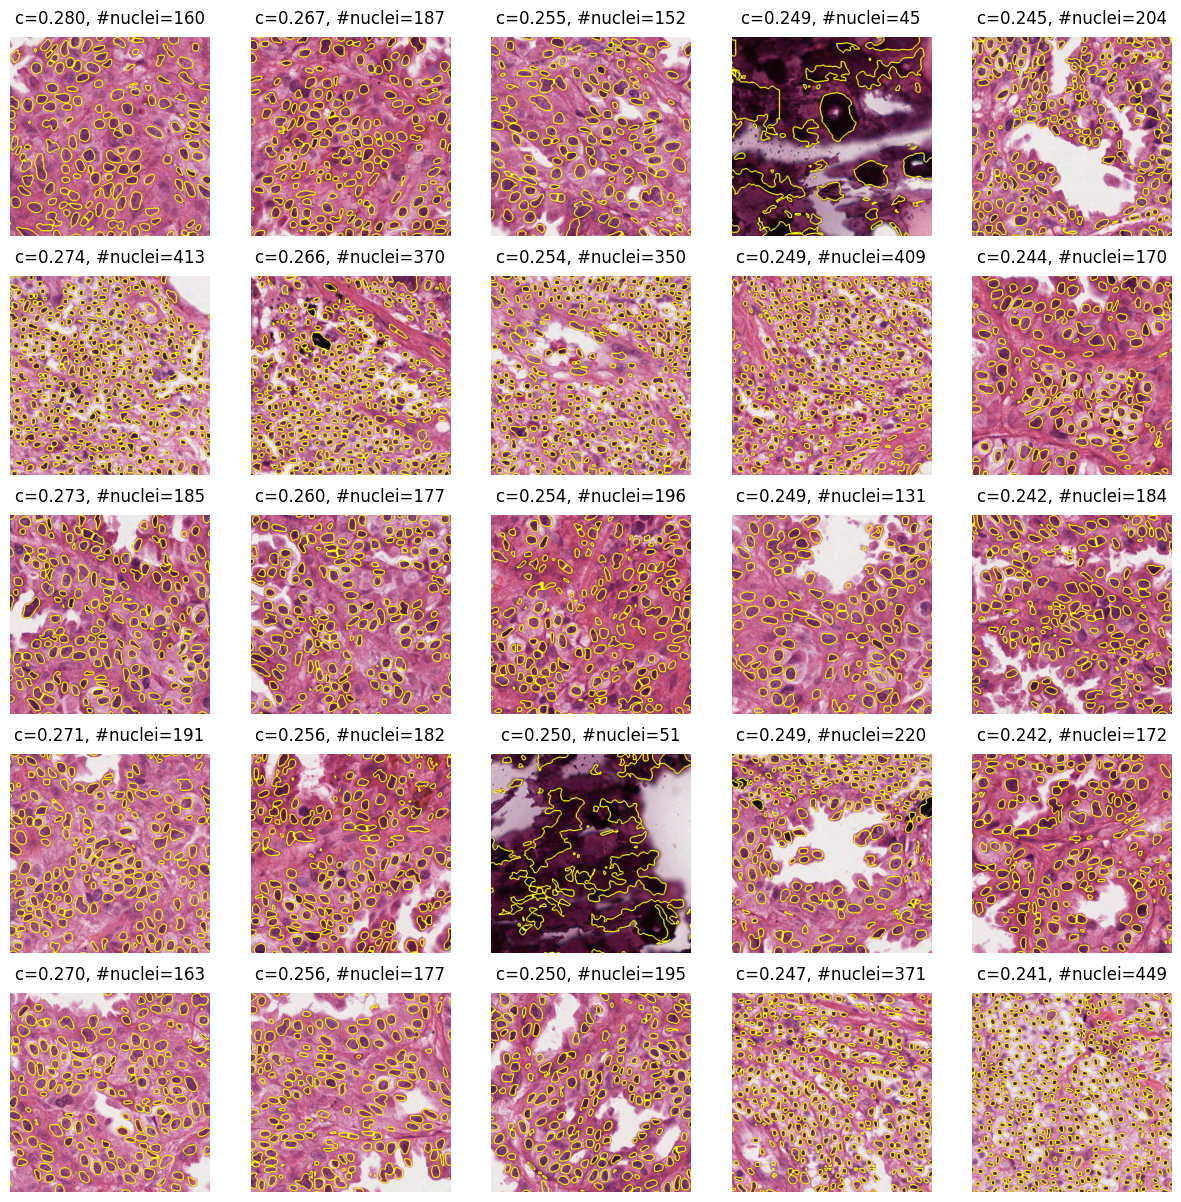

In [ ]:
sorted_by_cellularity = cellularity_per_tile.sort_values('cellularity', ascending=False)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, (_, row) in enumerate(sorted_by_cellularity[:25].iterrows()):
    tile = slide.read_region(row.tile_coordinates, size=(TILE_SIZE, TILE_SIZE), level=0)
    overlay = overlay_polygons(tile, row.tile_coordinates, row.overlapping_polygons)
    axes[i%5, i//5].imshow(overlay)
    axes[i%5, i//5].set_title(f'c={row.cellularity:.3f}, #nuclei={row.number_nuclei}', fontsize=12, pad=10)

for ax in axes.flat:
    ax.set_axis_off()
plt.show()

We can see that most tiles indeed contain a large number of nuclei, however there are two tiles clearly differing and likely showing artifacts where the algorithm predicted way too small, large or misshaped nuclei. In that case, the number of nuclei in a tile might be a better indicator of cellularity. Also cellularity as defined above will prefer less, but larger nuclei over more but smaller nuclei. Thus, below, we'll display the tiles with the largest number of nuclei.  

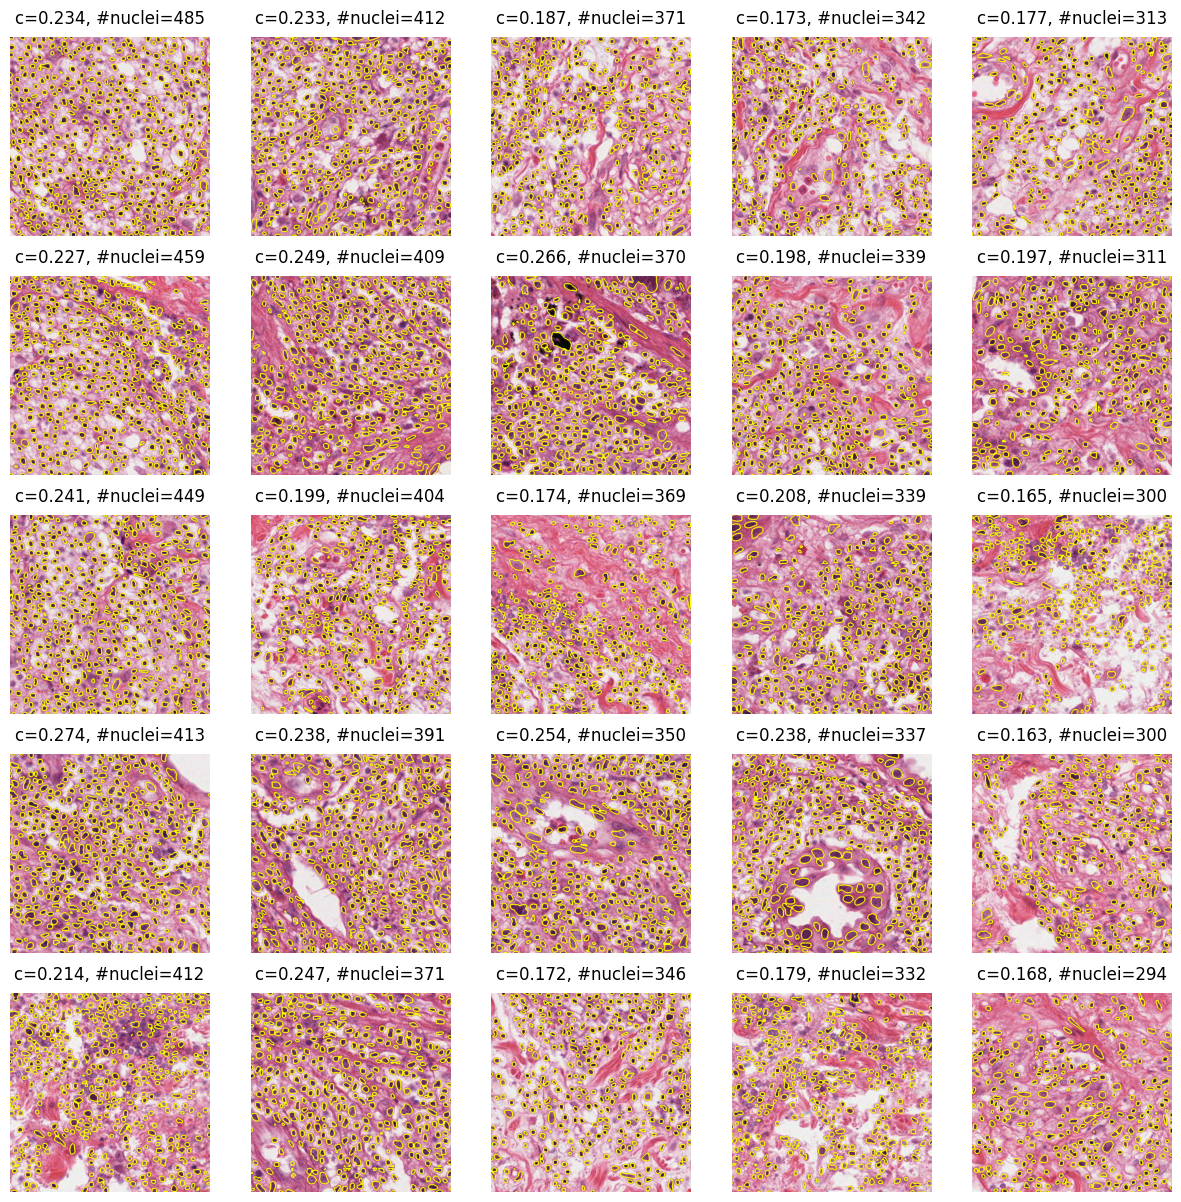

In [ ]:
sorted_by_nuclei_number = cellularity_per_tile.sort_values('number_nuclei', ascending=False)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, (_, row) in enumerate(sorted_by_nuclei_number[:25].iterrows()):
    tile = slide.read_region(row.tile_coordinates, size=(TILE_SIZE, TILE_SIZE), level=0)
    overlay = overlay_polygons(tile, row.tile_coordinates, row.overlapping_polygons)
    axes[i%5, i//5].imshow(overlay)
    axes[i%5, i//5].set_title(f'c={row.cellularity:.3f}, #nuclei={row.number_nuclei}', fontsize=12, pad=10)

for ax in axes.flat:
    ax.set_axis_off()
plt.show()

# Next steps
Share your feedback or ask questions about this notebook in IDC Forum: https://discourse.canceridc.dev.

If you are interested in tissue type annotations or want to learn about DICOM Structured Reporting, you can take a look at [this notebook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/collections_demos/rms_mutation_prediction/RMS-Mutation-Prediction-Expert-Annotations_exploration.ipynb) navigating expert-generated region annotations for rhabdomyosarcoma tumor slides.

